# Multi-class classifier: MNIST images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/5.multiclass-classifier-mnist.ipynb)

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [43]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [6]:
X.shape

(10000, 784)

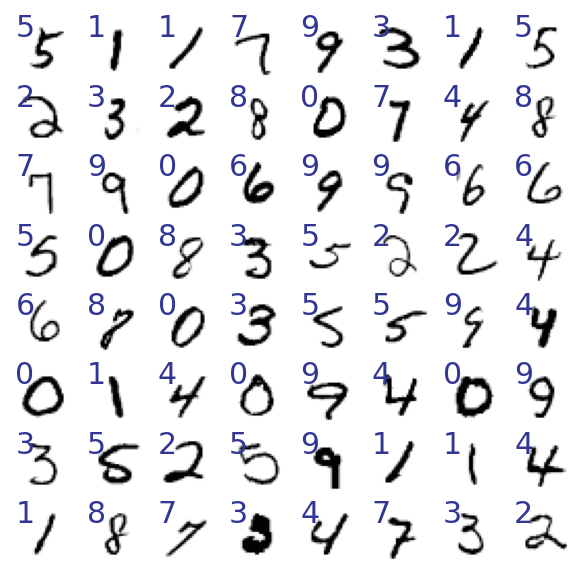

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [8]:
X = torch.tensor(X).float()
y = torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest baseline

In [9]:
cl = RandomForestClassifier(n_estimators=900, n_jobs=-1)
cl.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [10]:
y_train_accuracy = cl.score(X_train, y_train)
y_accuracy = cl.score(X_test, y_test)
y_train_accuracy, y_accuracy

(1.0, 0.9725)

## Vanilla one hidden layer of 50 neurons, softmax on end

In [95]:
def ctrain0(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")

In [107]:
model = nn.Sequential(
    nn.Linear(784, 50), # 50 neurons
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [108]:
ctrain0(model, X_train, y_train, learning_rate = .03, nepochs=1000)

Epoch     0 cross entropy loss  2.3041
Epoch   100 cross entropy loss  1.4893
Epoch   200 cross entropy loss  1.4831
Epoch   300 cross entropy loss  1.4823
Epoch   400 cross entropy loss  1.4809
Epoch   500 cross entropy loss  1.4804
Epoch   600 cross entropy loss  1.4793
Epoch   700 cross entropy loss  1.4781
Epoch   800 cross entropy loss  1.4779
Epoch   900 cross entropy loss  1.4779
Epoch  1000 cross entropy loss  1.4775
LAST        cross entropy loss  1.4775


In [109]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.983


In [110]:
conf = confusion_matrix(y_train, y_pred)
print(conf)

[[773   0   1   0   1   0   0   0   0   0]
 [  0 836   3   2   0   1   0   1   0   0]
 [  1   0 797   1   2   0   4   5   1   0]
 [  3   0   2 809   0   5   0   0   1   3]
 [  0   0   0   0 743   0   0   2   0   0]
 [  1   0   0   8   4 755   9   0   0   2]
 [  2   0   2   0   0   1 720   0   1   0]
 [  0   4   2   0   5   0   0 880   1   0]
 [  3   1   1  11   0   1   0   0 799   1]
 [  8   0   1   6  15   0   0   4   1 754]]


In [111]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.954


In [112]:
confusion_matrix(y_test, y_test_pred)
print(conf)

[[773   0   1   0   1   0   0   0   0   0]
 [  0 836   3   2   0   1   0   1   0   0]
 [  1   0 797   1   2   0   4   5   1   0]
 [  3   0   2 809   0   5   0   0   1   3]
 [  0   0   0   0 743   0   0   2   0   0]
 [  1   0   0   8   4 755   9   0   0   2]
 [  2   0   2   0   0   1 720   0   1   0]
 [  0   4   2   0   5   0   0 880   1   0]
 [  3   1   1  11   0   1   0   0 799   1]
 [  8   0   1   6  15   0   0   4   1 754]]


## Track validation versus training loss

In [180]:
def ctrain1(model, X_train, y_train, X_test, y_test, 
            learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [174]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [175]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3038   test loss        2.304
Epoch  200 cross entropy loss  1.4819   test loss        1.507
Epoch  400 cross entropy loss  1.4783   test loss        1.505
Epoch  600 cross entropy loss  1.4779   test loss        1.504
Epoch  800 cross entropy loss  1.4770   test loss        1.503
Epoch 1000 cross entropy loss  1.4765   test loss        1.502
Epoch 1200 cross entropy loss  1.4763   test loss        1.501
Epoch 1400 cross entropy loss  1.4762   test loss        1.501


KeyboardInterrupt: 

In [152]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.986


In [153]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.962


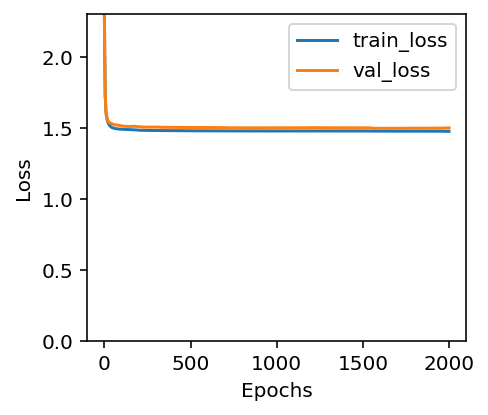

In [154]:
plot_loss(history)

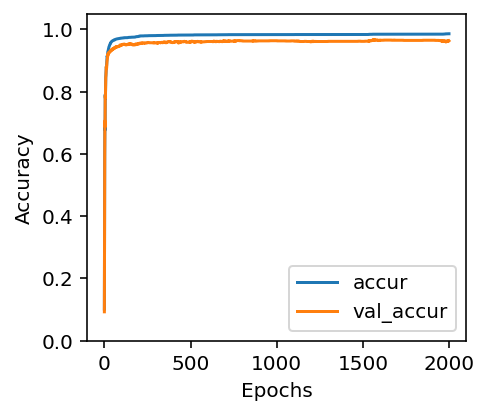

In [155]:
plot_accur(history)

## Use many neurons

In [208]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [209]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = 0.01, nepochs=1000)

Epoch    0 cross entropy loss  2.3026   test loss  2.3024
Epoch  100 cross entropy loss  1.4783   test loss  1.4994
Epoch  200 cross entropy loss  1.4748   test loss  1.4963
Epoch  300 cross entropy loss  1.4723   test loss  1.4941
Epoch  400 cross entropy loss  1.4714   test loss  1.4928
Epoch  500 cross entropy loss  1.4710   test loss  1.4913
Epoch  600 cross entropy loss  1.4707   test loss  1.4913
Epoch  700 cross entropy loss  1.4707   test loss  1.4914
Epoch  800 cross entropy loss  1.4707   test loss  1.4912
Epoch  900 cross entropy loss  1.4706   test loss  1.4912
Epoch 1000 cross entropy loss  1.4701   test loss  1.4913
LAST        cross entropy loss  1.4701


In [210]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.991


In [211]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.970


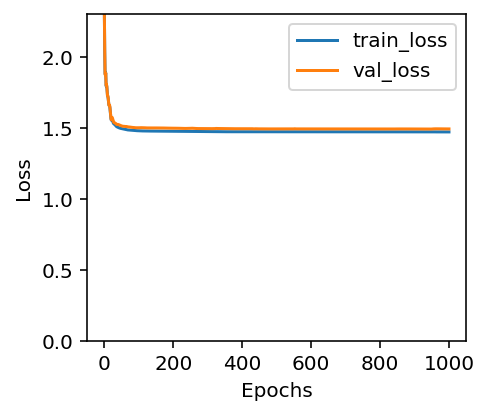

In [212]:
plot_loss(history)

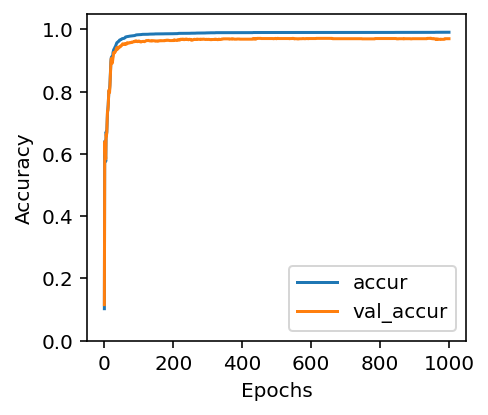

In [213]:
plot_accur(history)

## Cyclic learning rate

In [189]:
def ctrain2(model, X_train, y_train, X_test, y_test, 
            nepochs=2000,
            base_lr=0.01, max_lr=0.05):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  mode='triangular2',
                                                  step_size_up=500,
                                                  base_lr=base_lr, max_lr=max_lr,
                                                  cycle_momentum=False)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}   LR {scheduler.get_last_lr()[0]:7.6f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
        scheduler.step()
        
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [194]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [195]:
history = ctrain2(model, X_train, y_train, X_test, y_test,
                  base_lr=0.005, max_lr=0.03, nepochs=1000)

Epoch    0 cross entropy loss  2.3028   test loss  2.3030   LR 0.005000
Epoch   20 cross entropy loss  1.5369   test loss  1.5461   LR 0.006000
Epoch   40 cross entropy loss  1.5015   test loss  1.5226   LR 0.007000
Epoch   60 cross entropy loss  1.4877   test loss  1.5116   LR 0.008000
Epoch   80 cross entropy loss  1.4821   test loss  1.5034   LR 0.009000
Epoch  100 cross entropy loss  1.4781   test loss  1.5006   LR 0.010000
Epoch  120 cross entropy loss  1.4770   test loss  1.4991   LR 0.011000
Epoch  140 cross entropy loss  1.4760   test loss  1.4974   LR 0.012000
Epoch  160 cross entropy loss  1.4751   test loss  1.4961   LR 0.013000
Epoch  180 cross entropy loss  1.4739   test loss  1.4961   LR 0.014000
Epoch  200 cross entropy loss  1.4734   test loss  1.4940   LR 0.015000
LAST        cross entropy loss  1.4734


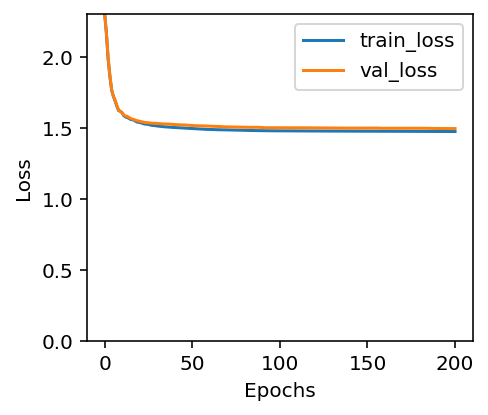

In [196]:
plot_loss(history)

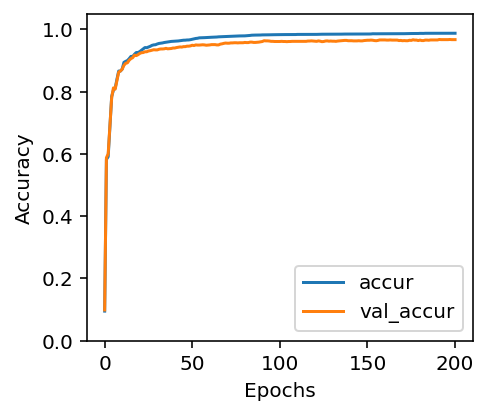

In [197]:
plot_accur(history)